# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')




In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
for index in feat_info.index:
    
    missing_or_unknown_codes = feat_info.iloc[index].missing_or_unknown.strip("[]").split(',')
    
    if(missing_or_unknown_codes!=['']):
        missing_symbol = [item if item in ['X','XX'] else int(item) for item in missing_or_unknown_codes]
        azdias[feat_info.iloc[index].attribute].replace(to_replace=missing_symbol,
                      value=np.nan, inplace=True)


In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_value_cols = azdias.isnull().sum()[azdias.isnull().sum()!=0].sort_values(ascending=False)
print(missing_value_cols)


TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

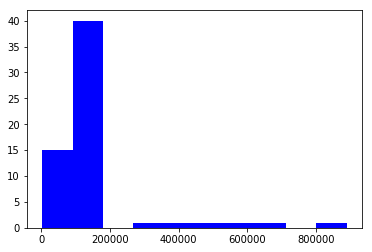

In [9]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_value_cols,facecolor='b')
plt.show()


In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_cols_dropped = missing_value_cols[missing_value_cols>200000]
print("Cols. to be dropped:")
print(missing_cols_dropped)


Cols. to be dropped:
TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
ALTER_HH        310267
dtype: int64


In [11]:
azdias.drop(missing_cols_dropped.index, axis=1, inplace=True)


#### Discussion 1.1.2: Assess Missing Data in Each Column

As we have seen in above cells, there are 61 columns which have null values out of 85 columns.

After calculating the total null values in each column, it is found that 6 columns namely: TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR and ALTER_HH have largest null values (i.e more than 200000 as observed from the histogram)                            

So,these columns should be dropped from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64


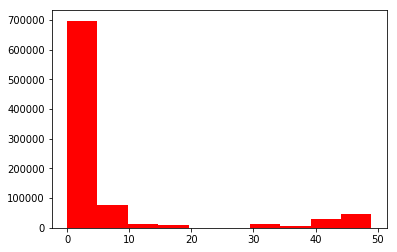

In [12]:
# How much data is missing in each row of the dataset?
null_rows_data = azdias.isnull().sum(axis=1)

print(null_rows_data.describe())

plt.hist(null_rows_data,facecolor='r')
plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
lower_missing_threshold = null_rows_data[null_rows_data < 20]
upper_missing_threshold = null_rows_data[null_rows_data >= 20]

print("Lower Threshold data:\n",lower_missing_threshold.describe())
print("\nUpper Threshold data:\n",upper_missing_threshold.describe())





Lower Threshold data:
 count    797077.000000
mean          1.245152
std           2.973833
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
dtype: float64

Upper Threshold data:
 count    94144.000000
mean        42.942960
std          5.312206
min         20.000000
25%         43.000000
50%         43.000000
75%         47.000000
max         49.000000
dtype: float64


In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

azdias.isnull().sum()[azdias.isnull().sum()==0].head()

ANREDE_KZ            0
FINANZ_MINIMALIST    0
FINANZ_SPARER        0
FINANZ_VORSORGER     0
FINANZ_ANLEGER       0
dtype: int64

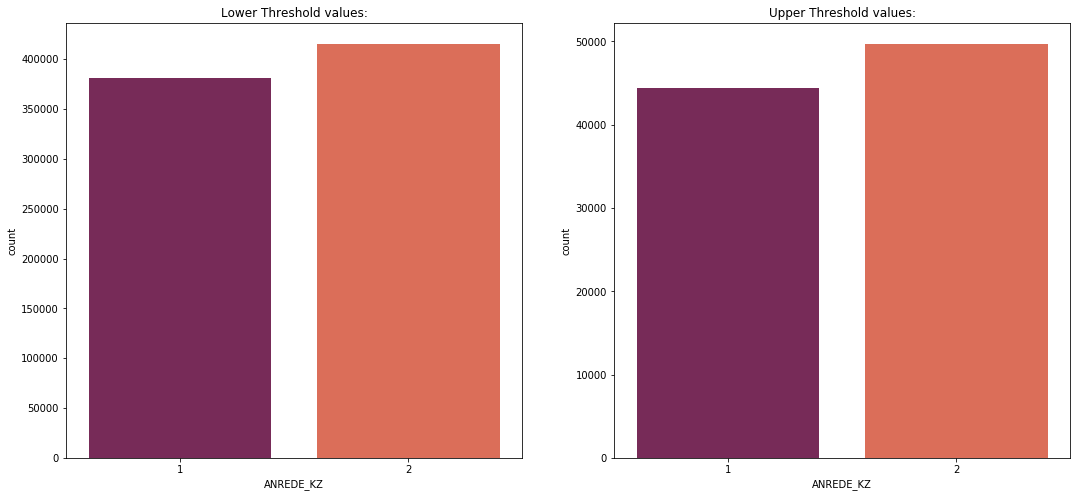

In [15]:
def plot_chart(columnName):
    fig = plt.figure(figsize=(18, 8))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text("Lower Threshold values:")
    sns.countplot(data=azdias.iloc[lower_missing_threshold.index], x=columnName, ax=ax1,palette="rocket")
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text("Upper Threshold values:")
    sns.countplot(data=azdias.iloc[upper_missing_threshold.index], x=columnName, ax=ax2,palette="rocket")
    
plot_chart("ANREDE_KZ")


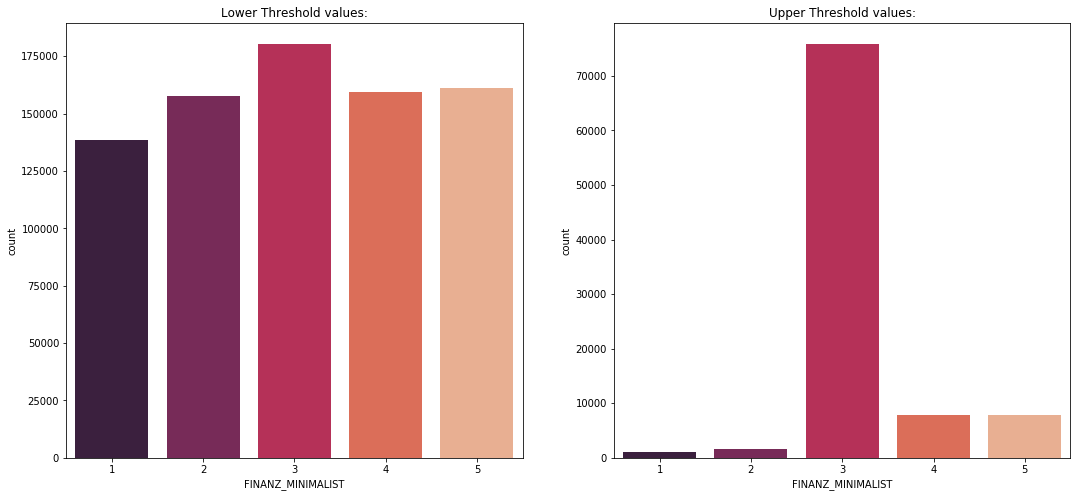

In [16]:
plot_chart("FINANZ_MINIMALIST")


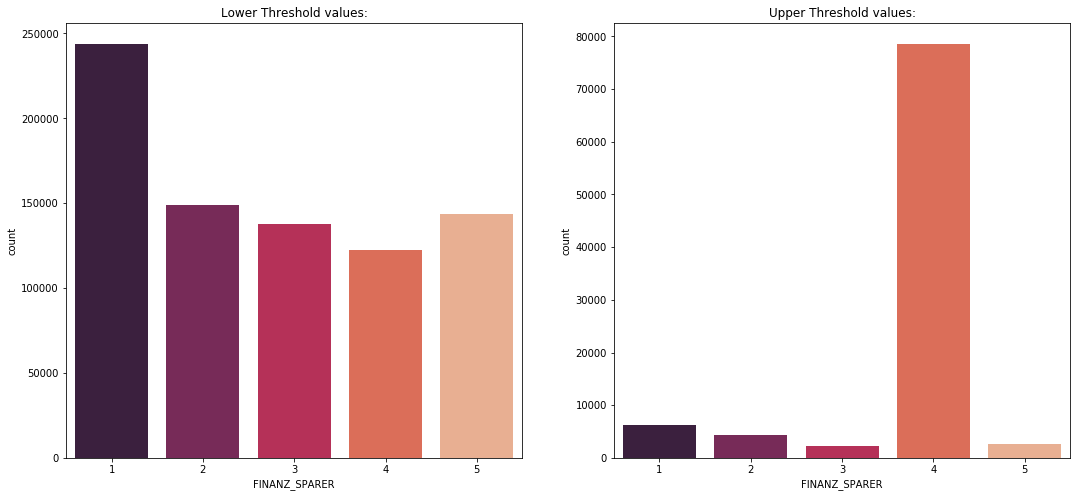

In [17]:
plot_chart("FINANZ_SPARER")


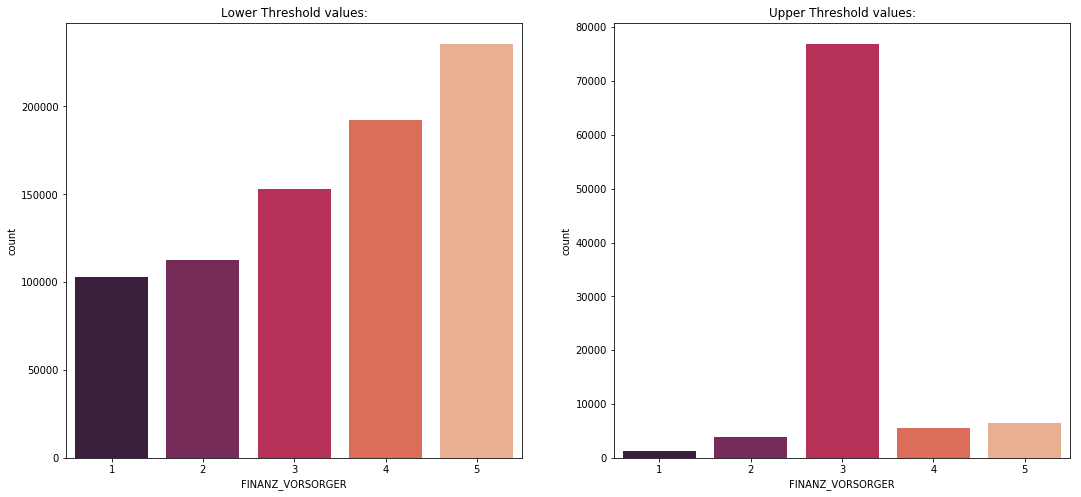

In [18]:
plot_chart("FINANZ_VORSORGER")


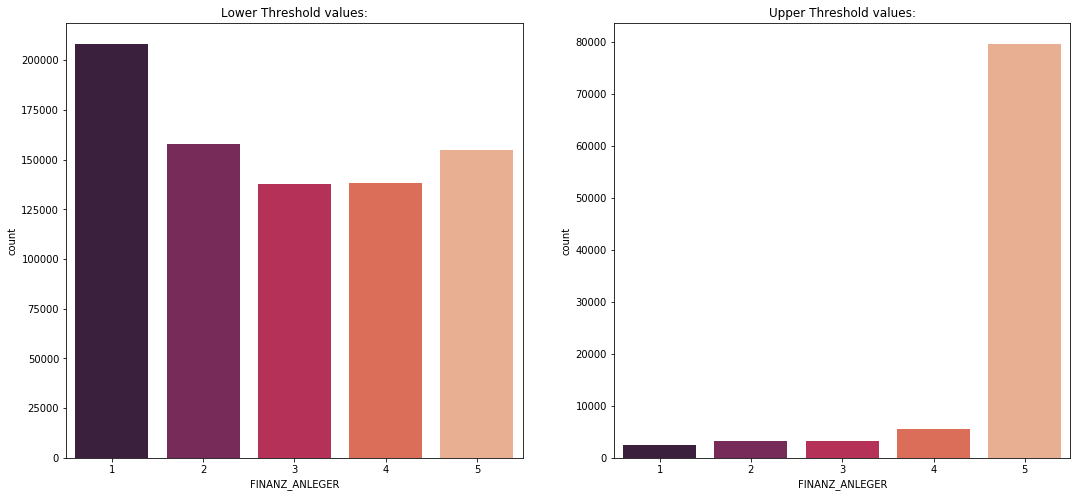

In [19]:
plot_chart("FINANZ_ANLEGER")

#### Discussion 1.1.3: Assess Missing Data in Each Row

As per the histogram of the missing values of data in each row, the threshold value taken is 20 and based on this value the data is divided into two sets one having lower null/missing values than the threshold value and other set having higher values than the threshold value.

The lower thrshold set has 797077 rows and upper threshold set has 94144 rows out of the total 891221 rows in entire data set.

Also, the columns with minimum null values compared in both the sets are ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER.The plot show the distribution of columns in both the sets


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
feat_info.head()



,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [21]:
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = feat_info[feat_info.type == 'categorical'].attribute
filtered_categorical_columns =[attr for attr in categorical_columns if attr in azdias.columns]
print("Categorical Variables:\n",azdias[filtered_categorical_columns].nunique())

binary_categorical_variables = [attr for attr in filtered_categorical_columns if azdias[attr].nunique()==2]
print("\n\nBinary Categorical Variables:\n",azdias[binary_categorical_variables].nunique())

multilevel_categorical_variables = [attr for attr in filtered_categorical_columns if azdias[attr].nunique()>2]
print("\n\nMultilevel Categorical Variables:\n",azdias[multilevel_categorical_variables].nunique())


Categorical Variables:
 ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64


Binary Categorical Variables:
 ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64


Multilevel Categorical Variables:
 CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64


In [23]:
for item in binary_categorical_variables:
    print(azdias[item].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


In [24]:
azdias['OST_WEST_KZ'].replace(['O','W'], [0,1], inplace=True)

In [25]:
for item in binary_categorical_variables:
    print(azdias[item].value_counts())

2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2.0    398722
1.0    381303
Name: VERS_TYP, dtype: int64
1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias = pd.get_dummies(azdias, columns=multilevel_categorical_variables)

#### Discussion 1.2.1: Re-Encode Categorical Features

As seen in the above cells, 21 columns have categorical data and after removing the columns which are removed from the dataset the value is 18 for categorical variables. 

On further analysis it is found that out of 18, 5 variables are binary and 13 are multilevel. Since it was easy to handle multilevel data, they have been hot-encoded.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias[['PRAEGENDE_JUGENDJAHRE']].head()


,PRAEGENDE_JUGENDJAHRE
0,NaN
1,14.0
2,15.0
3,8.0
4,8.0


In [28]:
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts().sort_values(ascending=False)

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [29]:
#Decade/generation Dictionary 
generations_dict = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s

# Movement Dictionary (Mainstream=1 and Avantgarde=0)
mainstream_dict = [1, 3, 5, 8, 10, 12, 14]

def gen_classifier(value):
    try:
        for key, values in generations_dict.items():
            if value in values:
                return key
    except ValueError:
        return np.nan
    

def movement_classifier(value):
    try:
        if value in mainstream_dict:
            return 1
        else:
            return 0
    except ValueError:
        return np.nan

In [30]:
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(gen_classifier)

azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(movement_classifier)

In [31]:
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].head(10)

0    NaN
1    5.0
2    5.0
3    3.0
4    3.0
5    1.0
6    4.0
7    3.0
8    4.0
9    5.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64

In [32]:
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].head(10)

0    0
1    1
2    0
3    1
4    1
5    1
6    1
7    1
8    0
9    0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].head(10)


0    NaN
1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
Name: CAMEO_INTL_2015, dtype: object

In [34]:
def lifestage_map(value):
    if pd.isnull(value):
        return np.nan
    else:
        return int(int(value)%10)
    
def wealth_map(value):
    if pd.isnull(value):
        return np.nan
    else:
        return int(value)//10
    

In [35]:
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(wealth_map)

azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(lifestage_map)

In [36]:
azdias['CAMEO_INTL_2015_WEALTH'].head(10)

0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
6    2.0
7    1.0
8    1.0
9    1.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [37]:
azdias['CAMEO_INTL_2015_LIFESTAGE'].head(10)

0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
6    2.0
7    4.0
8    3.0
9    5.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

In [38]:
azdias.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In the above steps, two new features each in PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 are created based on the instructions given and the new engineered features are PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT for Decade and Movement in PRAEGENDE_JUGENDJAHRE.
 
And CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE in CAMEO_INTL_2015 for wealth and lifestage. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
np.unique(azdias.dtypes.values)



array([dtype('uint8'), dtype('int64'), dtype('float64')], dtype=object)

In [40]:
azdias.head(10).T

,0,1,2,3,4,5,6,7,8,9
ALTERSKATEGORIE_GROB,2.0,1.0,3.0,4.0,3.0,1.0,2.0,1.0,3.0,3.0
ANREDE_KZ,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0
FINANZ_MINIMALIST,3.0,1.0,1.0,4.0,4.0,3.0,1.0,3.0,4.0,2.0
FINANZ_SPARER,4.0,5.0,4.0,2.0,3.0,1.0,5.0,3.0,4.0,4.0
FINANZ_VORSORGER,3.0,2.0,1.0,5.0,4.0,5.0,1.0,4.0,2.0,2.0
FINANZ_ANLEGER,5.0,5.0,2.0,2.0,1.0,2.0,5.0,1.0,4.0,3.0
FINANZ_UNAUFFAELLIGER,5.0,4.0,3.0,1.0,3.0,2.0,4.0,3.0,2.0,5.0
FINANZ_HAUSBAUER,3.0,5.0,5.0,2.0,2.0,5.0,3.0,2.0,2.0,4.0
GREEN_AVANTGARDE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
HEALTH_TYP,NaN,3.0,3.0,2.0,3.0,3.0,2.0,1.0,3.0,2.0


In [41]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#removing rows with high null values
azdias = azdias[~azdias.index.isin(upper_missing_threshold.index)]

In [42]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
count,794304.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,760739.000000,...,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,797077.000000,768753.000000,797077.000000,791210.000000,791210.00000
mean,2.795177,1.521377,3.058727,2.715815,3.432951,2.840685,2.656884,3.115607,0.219722,2.199332,...,0.022037,0.025765,0.034703,0.031347,0.035870,0.007983,3.331905,0.744744,3.262615,2.87291
std,1.018528,0.499543,1.377570,1.485032,1.376959,1.472527,1.399118,1.407806,0.414058,0.755127,...,0.146803,0.158435,0.183027,0.174254,0.185966,0.088990,1.457350,0.436006,1.464535,1.48489
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.00000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,4.000000,3.00000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,5.000000,4.00000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,5.00000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(data):

    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Identify missing or unknown data values and convert them to NaNs.
    df = data.copy()
    for index in feat_info.index:
    
        missing_or_unknown_codes = feat_info.iloc[index].missing_or_unknown.strip("[]").split(',')
    
        if(missing_or_unknown_codes!=['']):
            missing_symbol = [item if item in ['X','XX'] else int(item) for item in missing_or_unknown_codes]
            df[feat_info.iloc[index].attribute].replace(to_replace=missing_symbol,value=np.nan, inplace=True)
            
    #drop the missing columns
    df.drop(missing_cols_dropped.index, axis=1, inplace=True)
    
    #getting null rows data
    null_rows_data = df.isnull().sum(axis=1)
    lower_missing_threshold = null_rows_data[null_rows_data < 20]
    upper_missing_threshold = null_rows_data[null_rows_data >= 20]
    df = df[~df.index.isin(upper_missing_threshold.index)]
    
    df['OST_WEST_KZ'].replace(['O','W'], [0,1], inplace=True)
    df = pd.get_dummies(df, columns=multilevel_categorical_variables)
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(gen_classifier)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement_classifier)
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth_map)
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lifestage_map)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1,inplace=True)

    
    # Return the cleaned dataframe.
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_copy = azdias.copy()

imputer = Imputer(strategy='mean')
imputer = imputer.fit(azdias_copy)
azdias_copy = pd.DataFrame(imputer.transform(azdias_copy), columns = azdias_copy.columns)



In [45]:
azdias_copy.isnull().sum()

ALTERSKATEGORIE_GROB              0
ANREDE_KZ                         0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
GREEN_AVANTGARDE                  0
HEALTH_TYP                        0
LP_LEBENSPHASE_FEIN               0
LP_LEBENSPHASE_GROB               0
RETOURTYP_BK_S                    0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT                     0
SEMIO_TRADV                       0
SOHO_KZ                     

In [46]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(azdias_copy)


In [47]:
scaled_data = pd.DataFrame(scaled_data, columns = azdias_copy.columns)
scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-1.765596,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.165504,0.585443,1.190696,-1.265981
1,0.201448,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.165504,-1.708107,-0.865318,0.761849
2,1.184971,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.270203,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.231903,0.585443,-1.550656,-0.590038
3,0.201448,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.231903,0.585443,0.505358,0.085906
4,-1.765596,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.085338,...,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-1.629311,0.585443,1.190696,0.761849


### Discussion 2.1: Apply Feature Scaling

In the above cells, we have used Imputer with mean as the strategy to impute the nulls and NaN values.

Also, we have used StandardScaler to scale the data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(scaled_data)


In [49]:
pd.DataFrame(azdias_pca).head()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,4.310444,-4.252295,-3.130512,1.586699,0.714280,1.889802,-0.377032,0.120298,-0.798481,2.803663,...,9.193899e-14,-7.276997e-14,-2.839642e-14,-8.534913e-15,5.469082e-14,3.701729e-14,7.408108e-14,-3.530224e-14,-1.260850e-14,-1.808185e-16
1,-0.130244,-0.472202,-3.364291,-0.314745,-4.334781,1.709164,-1.017999,0.184562,-0.798617,-1.251815,...,2.422976e-13,-6.272597e-14,-6.358832e-14,5.677672e-14,-2.650741e-14,-6.702558e-14,1.649149e-14,-1.178890e-13,-4.102033e-14,-3.551901e-16
2,-4.809982,1.862500,-1.421530,-2.067194,0.826678,-2.241355,1.076213,-1.159938,-0.339400,0.536236,...,-5.480298e-14,-7.570819e-14,6.974689e-14,7.040416e-14,-5.419918e-14,-3.761906e-14,-2.810573e-16,-4.090057e-14,-8.104142e-15,5.459564e-17
3,-0.550962,0.226028,3.263971,2.669187,2.651251,2.200784,-3.343869,2.613310,-0.724150,-3.577118,...,3.716292e-13,-2.222670e-13,-1.585104e-14,5.652049e-14,5.160168e-14,4.897543e-14,-6.728908e-14,-7.506539e-14,-3.451296e-14,-5.879549e-16
4,-0.497794,-0.666299,-1.469403,-4.194082,-0.311117,2.859512,-2.350609,-0.386605,-0.466339,0.123148,...,-1.735823e-12,8.188620e-13,3.665127e-14,-5.228379e-13,-4.896634e-13,-4.426232e-13,-5.130853e-13,1.662308e-13,-1.703558e-14,1.837844e-15


In [50]:
pca.explained_variance_ratio_

array([  8.26685513e-02,   5.71083034e-02,   3.49716626e-02,
         2.99796800e-02,   2.38849833e-02,   1.60446429e-02,
         1.50333399e-02,   1.34068654e-02,   1.29753115e-02,
         1.25076764e-02,   1.19529653e-02,   1.17985501e-02,
         1.14943541e-02,   1.13831494e-02,   1.11577788e-02,
         1.09372856e-02,   1.07094622e-02,   1.05903764e-02,
         1.04260961e-02,   1.02703143e-02,   1.00070029e-02,
         9.68594984e-03,   9.40151906e-03,   9.03693402e-03,
         8.57923209e-03,   8.33707152e-03,   8.21515225e-03,
         7.90861526e-03,   7.39509082e-03,   7.19340191e-03,
         7.06177511e-03,   6.98758532e-03,   6.75803250e-03,
         6.69885653e-03,   6.65236557e-03,   6.56842036e-03,
         6.48917008e-03,   6.27246936e-03,   6.16836530e-03,
         6.05855667e-03,   6.03109618e-03,   5.83670411e-03,
         5.76106764e-03,   5.71460095e-03,   5.68815991e-03,
         5.63290091e-03,   5.59546512e-03,   5.53394796e-03,
         5.50959125e-03,

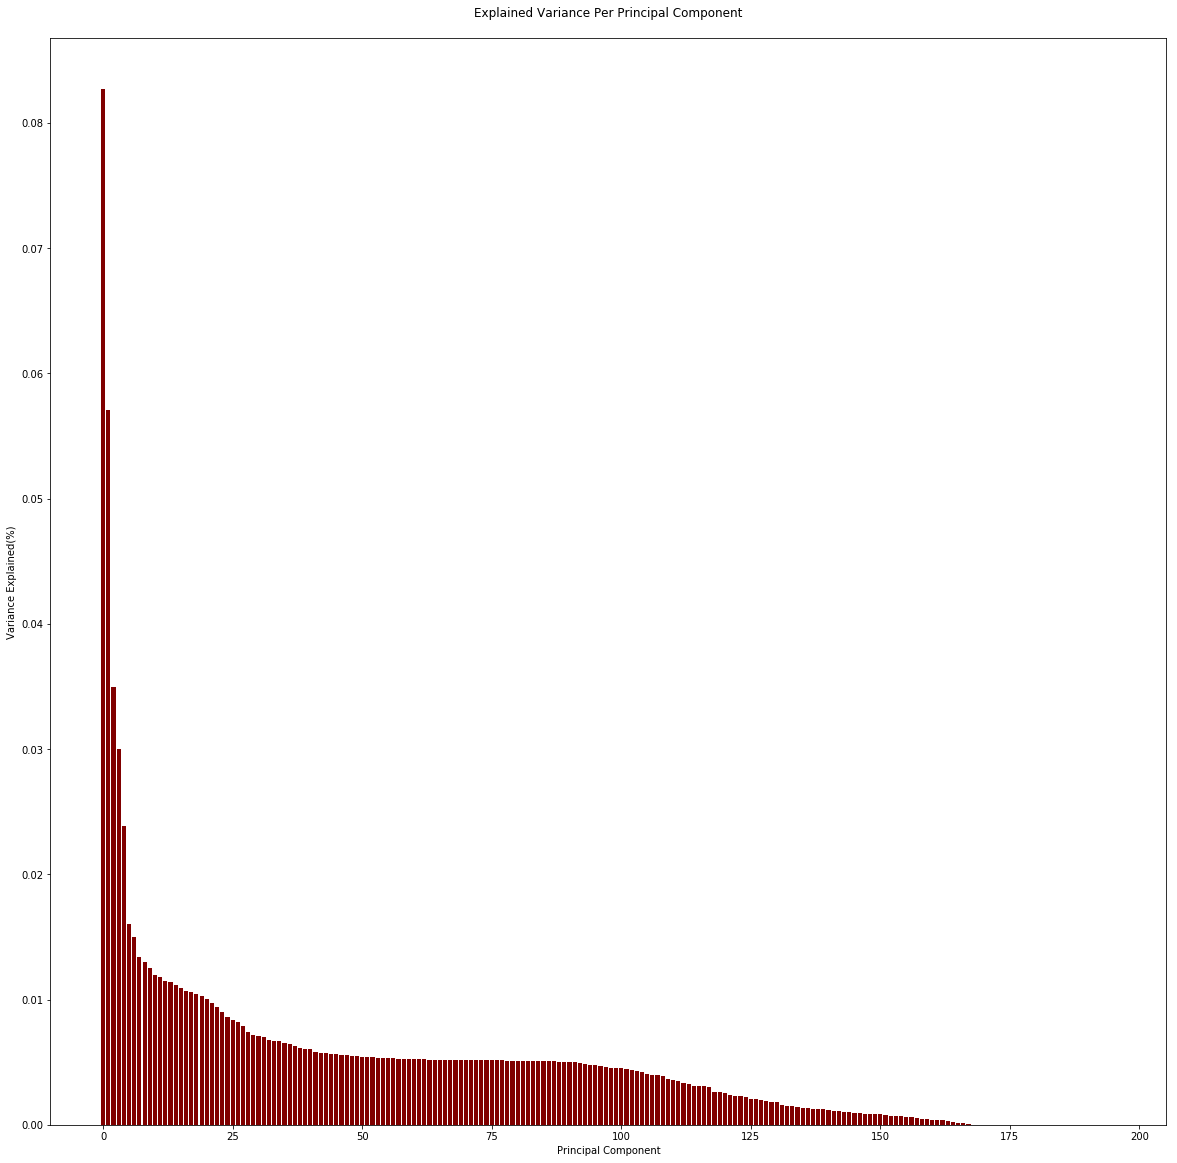

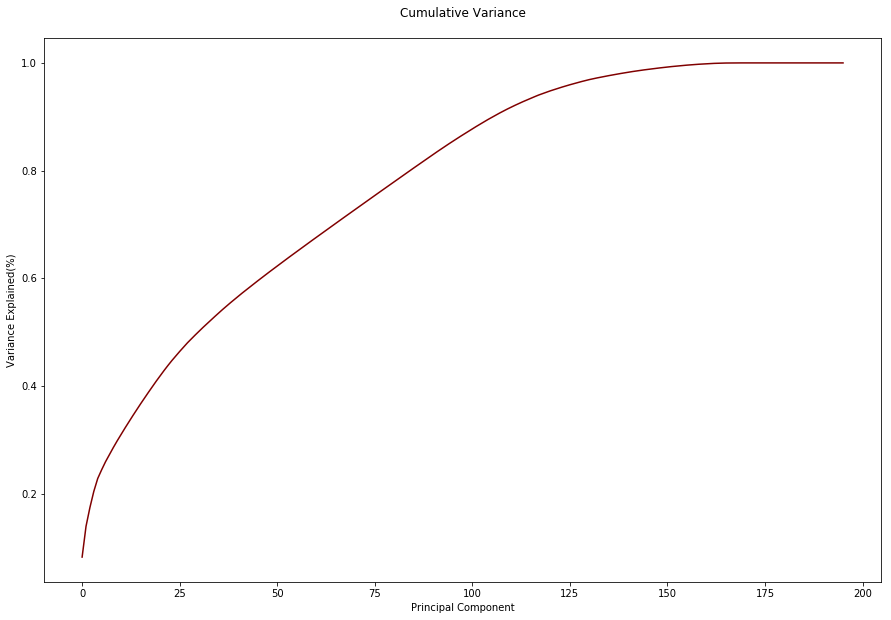

In [51]:
# Investigate the variance accounted for by each principal component.
def pca_variance_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    index = np.arange(num_components)
    values = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20,20))
    plt.bar(index, values, color ='maroon')
    plt.legend(fontsize = 20)

    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained(%)")
    plt.title('Explained Variance Per Principal Component\n')
    
def cumvariance_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    index = np.arange(num_components)
    values = pca.explained_variance_ratio_
    cumvalues = np.cumsum(values)
    plt.figure(figsize=(15,10))
    plt.plot(index, cumvalues, color ='maroon')
    plt.legend(fontsize = 16)
 
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained(%)")
    plt.title('Cumulative Variance\n')

    
    
pca_variance_plot(pca)
cumvariance_plot(pca)

In [52]:
for i in np.arange(80, len(pca.explained_variance_ratio_), 10):
    print('{} components -> {}% of variance'.format(i,(pca.explained_variance_ratio_[:i].sum()) * 100))

80 components -> 77.4392934353457% of variance
90 components -> 82.52266941586743% of variance
100 components -> 87.29866909354597% of variance
110 components -> 91.44778563051432% of variance
120 components -> 94.5632203213172% of variance
130 components -> 96.72474200222403% of variance
140 components -> 98.15629162369812% of variance
150 components -> 99.15360053599456% of variance
160 components -> 99.79515380006667% of variance
170 components -> 100.0% of variance
180 components -> 100.0% of variance
190 components -> 100.0% of variance


In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=100)
azdias_pca = pca.fit_transform(scaled_data)



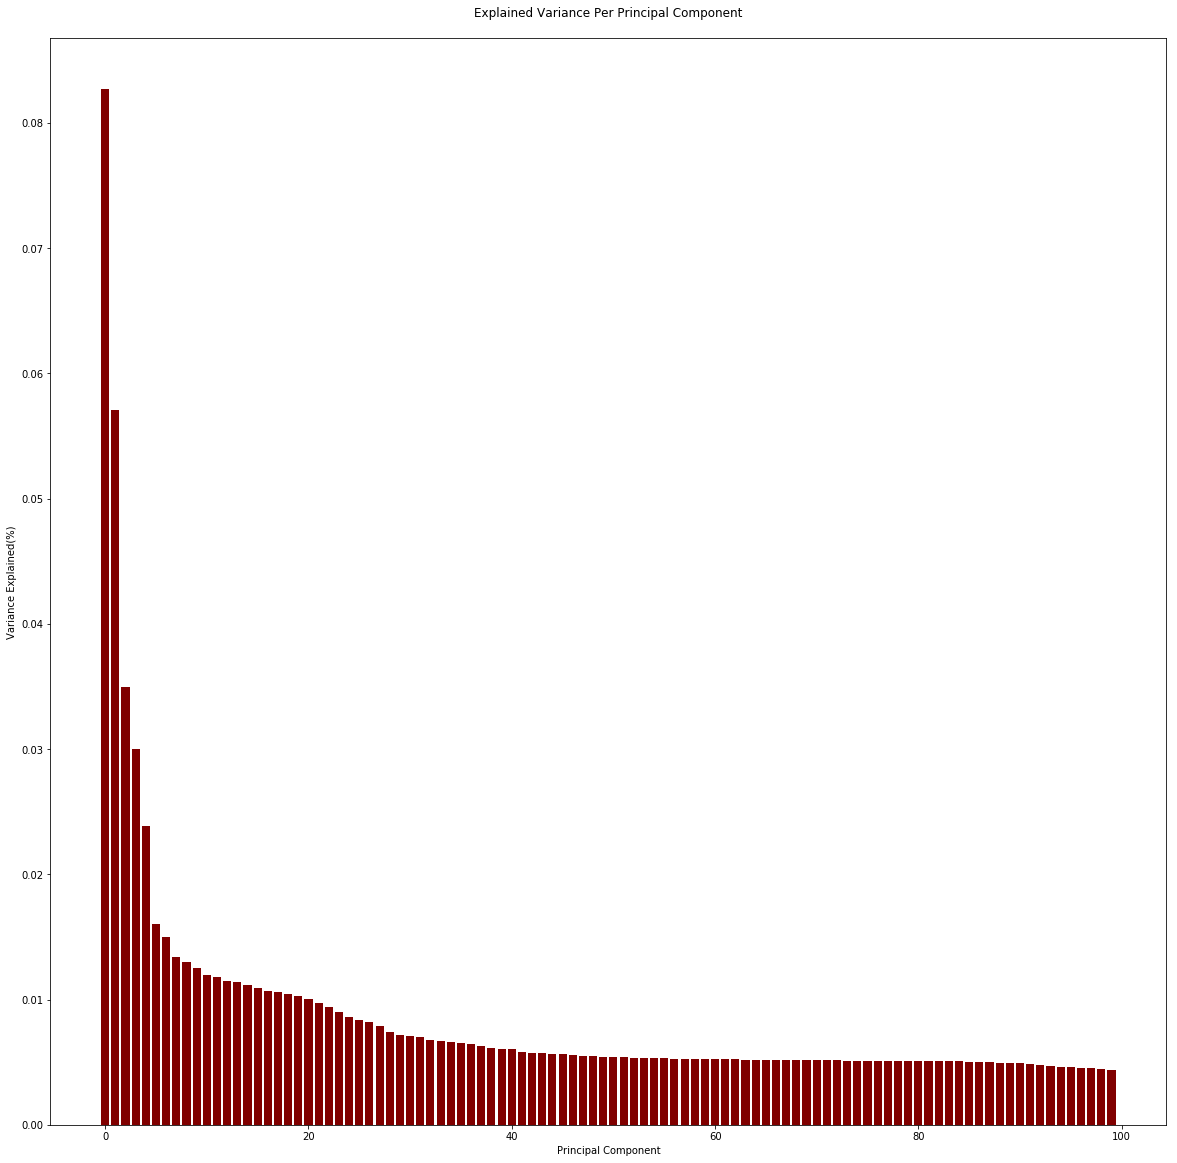

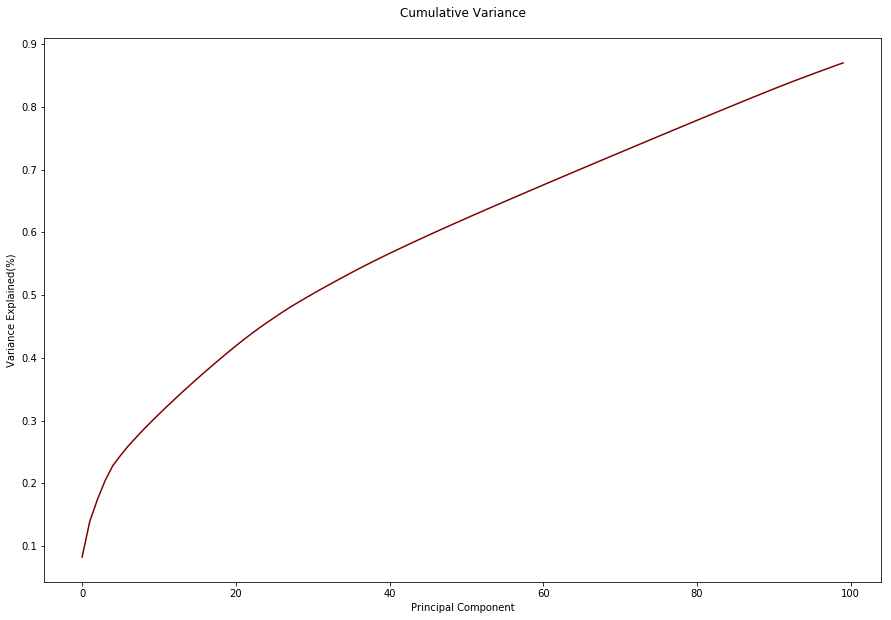

In [54]:
pca_variance_plot(pca)
cumvariance_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

In the above cells, we have seen that after applying PCA on scaled data, almost around 100 components explain around 87.3% variance. 

So it was sufficient to keep these features for the PCA.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weight_map(data,pca, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(data.columns))
    pca_component = pd.DataFrame(pca_df.iloc[component])
    print(pca_component.sort_values(component, ascending=False))

    
weight_map(azdias_copy,pca,0)


                                       0
LP_STATUS_GROB_1.0              0.188860
CAMEO_INTL_2015_WEALTH          0.180016
HH_EINKOMMEN_SCORE              0.179941
PLZ8_ANTG3                      0.179789
PLZ8_ANTG4                      0.174548
PLZ8_BAUMAX                     0.170392
ORTSGR_KLS9                     0.153803
EWDICHTE                        0.152187
FINANZ_HAUSBAUER                0.146951
LP_STATUS_FEIN_1.0              0.127139
KBA05_ANTG4                     0.124475
PLZ8_ANTG2                      0.123178
ANZ_HAUSHALTE_AKTIV             0.113142
ARBEIT                          0.111902
KBA05_ANTG3                     0.111244
CAMEO_DEUG_2015_9               0.110254
LP_STATUS_FEIN_2.0              0.106127
RELAT_AB                        0.105677
FINANZTYP_1                     0.101854
FINANZ_SPARER                   0.099610
LP_FAMILIE_GROB_1.0             0.098761
LP_FAMILIE_FEIN_1.0             0.098761
CAMEO_DEUG_2015_8               0.090529
PRAEGENDE_JUGEND

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_map(azdias_copy,pca,1)



                                     1
ALTERSKATEGORIE_GROB          0.237381
FINANZ_VORSORGER              0.223379
ZABEOTYP_3                    0.199170
SEMIO_ERL                     0.180929
SEMIO_LUST                    0.166069
RETOURTYP_BK_S                0.155409
W_KEIT_KIND_HH                0.127812
CJT_GESAMTTYP_2.0             0.110931
FINANZ_MINIMALIST             0.101801
FINANZTYP_5                   0.097757
FINANZTYP_2                   0.097080
LP_STATUS_FEIN_1.0            0.086084
SHOPPER_TYP_3.0               0.075284
FINANZ_HAUSBAUER              0.074896
CJT_GESAMTTYP_1.0             0.071691
NATIONALITAET_KZ_1.0          0.071413
SEMIO_KRIT                    0.070606
FINANZTYP_6                   0.068641
LP_FAMILIE_GROB_1.0           0.059311
LP_FAMILIE_FEIN_1.0           0.059311
GFK_URLAUBERTYP_4.0           0.057952
WOHNDAUER_2008                0.056992
EWDICHTE                      0.052918
SEMIO_KAEM                    0.052569
ORTSGR_KLS9              

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight_map(azdias_copy,pca,2)


                                       2
SEMIO_VERT                      0.316960
SEMIO_FAM                       0.257876
SEMIO_SOZ                       0.255267
SEMIO_KULT                      0.249147
FINANZTYP_5                     0.135816
FINANZ_MINIMALIST               0.132067
SHOPPER_TYP_0.0                 0.121901
ZABEOTYP_1                      0.121320
SEMIO_REL                       0.112588
SEMIO_MAT                       0.087840
GREEN_AVANTGARDE                0.084041
RETOURTYP_BK_S                  0.073788
ORTSGR_KLS9                     0.068735
EWDICHTE                        0.068223
LP_STATUS_GROB_5.0              0.061260
LP_STATUS_FEIN_10.0             0.061260
W_KEIT_KIND_HH                  0.057298
PLZ8_BAUMAX                     0.053260
SHOPPER_TYP_1.0                 0.052601
PLZ8_ANTG4                      0.051066
PLZ8_ANTG3                      0.050372
ZABEOTYP_6                      0.046506
FINANZ_VORSORGER                0.046208
LP_STATUS_FEIN_3

### Discussion 2.3: Interpret Principal Components

##### For First Principal Component:

The first principal component has positive association with with LP_STATUS_GROB_1.0(Social status, rough scale - low-income earners), CAMEO_INTL_2015_WEALTH(German CAMEO: Wealth),HH_EINKOMMEN_SCORE(Estimated household net income)

The first principal component has negative association with with MOBI_REGIO(Movement patterns) ,KBA05_ANTG1(Number of 1-2 family houses in the microcell),PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region)                     

This component is strongly associated with the social status of the population and their movement patterns along with their wealth, net income, number of 1-2 family houses in microcell and PLZ8 region.


##### For Second Principal Component:

The second principal component has positive association with ALTERSKATEGORIE_GROB (Estimated age based on given name analysis),FINANZ_VORSORGER(Financial typology, be prepared),ZABEOTYP_3(Energy consumption typology,fair supplied)

The second principal component has negative association with PRAEGENDE_JUGENDJAHRE_DECADE(Dominating movement of person's youth -Decade),FINANZ_SPARER(Financial typology,money-saver), SEMIO_REL(Personality typology,Religious)                                     

This component is strongly associated with the estimated age and decade of movement of youth along with financial topology.



##### For Third Principal Component:

The third principal component has positive association with SEMIO_VERT(Personality typology, dreamful),SEMIO_FAM(Personality typology, family-minded),SEMIO_SOZ(Personality typology, socially-minded)

The third principal component has negative association with ANREDE_KZ(Gender),SEMIO_KAEM(Personality typology, combative attitude), SEMIO_DOM(Personality typology, dominant-minded)                  

This component is strongly associated with the Personality typology and gender.






## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
# Over a number of different cluster counts...
azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.20), replace=False)]
azdias_pca_sample 


    

array([[-2.88479386,  5.35687641, -1.63429808, ..., -0.41548724,
         0.16326687, -0.19056898],
       [-3.93713939, -5.74445359,  3.66673703, ...,  1.56505196,
        -0.4612883 ,  1.20079481],
       [-2.15228065,  0.75443551, -2.3974707 , ...,  0.37782355,
        -0.34694764,  0.90904888],
       ..., 
       [ 5.35618293, -1.91954397,  2.19429935, ...,  1.51452167,
         0.66513153, -1.23085765],
       [-5.4675582 ,  0.92195048,  1.96068881, ...,  0.18852451,
         0.33066656,  0.18138409],
       [ 3.85186575,  6.7266848 , -2.13147469, ...,  1.38443031,
         0.7191198 ,  0.05471107]])

In [59]:
clusters = np.arange(2,16)
scores =[]
for cluster in clusters:
    model = KMeans(cluster,max_iter=25)
    model.fit(azdias_pca_sample)
    scores.append(abs(model.score(azdias_pca_sample)))
    print(f'{cluster} Clusters: {abs(model.score(azdias_pca_sample)):.3f}')
    

2 Clusters: 25807012.101
3 Clusters: 24917514.381
4 Clusters: 24134679.518
5 Clusters: 23840391.621
6 Clusters: 23057558.580
7 Clusters: 22766712.813
8 Clusters: 22629082.227
9 Clusters: 22280256.882
10 Clusters: 22091328.707
11 Clusters: 21826474.732
12 Clusters: 21766310.461
13 Clusters: 21572010.230
14 Clusters: 21401019.724
15 Clusters: 21182246.640


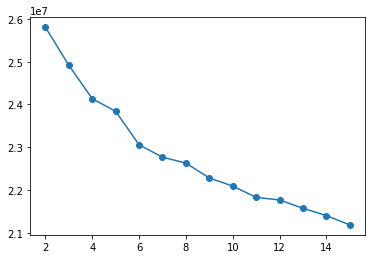

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters,scores,marker="o")
plt.show()


In [61]:
clusters = np.arange(16,21)
scores =[]
for cluster in clusters:
    model = KMeans(cluster,max_iter=25)
    model.fit(azdias_pca_sample)
    scores.append(abs(model.score(azdias_pca_sample)))
    print(f'{cluster} Clusters: {abs(model.score(azdias_pca_sample)):.3f}')

16 Clusters: 21186867.585
17 Clusters: 20924528.661
18 Clusters: 20884875.242
19 Clusters: 20628218.525
20 Clusters: 20527200.517


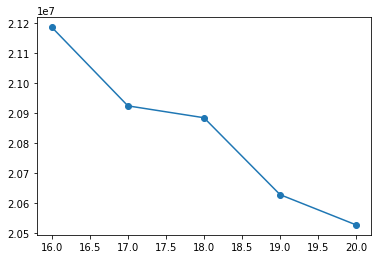

In [62]:
plt.plot(clusters,scores,marker="o")
plt.show()

In [63]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_model = KMeans(n_clusters=15)
general_model = kmeans_model.fit(azdias_pca)
general_prediction = general_model.predict(azdias_pca)

In [64]:
general_prediction

array([ 3,  2, 10, ...,  2,  5, 13], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

After the analysis on the clusters score, it is observed that the score changes less frequently after 15 clusters and almost remains constant with very less difference in the score.

So, 15 clusters will be considered for this analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customers = clean_data(customers)
cleaned_customers.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,1.0,0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,1.0,0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0.0,1,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0,3.0,1,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,0,1.0,0,3.0,4.0


In [67]:
list(set(azdias.columns) - set(cleaned_customers))

['GEBAEUDETYP_5.0']

In [68]:
customers['GEBAEUDETYP'].value_counts()


1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

In [69]:
cleaned_customers.shape

(141590, 195)

In [70]:
customers.shape[0]

191652

In [71]:
customers_copy = customers.copy()
customers_copy = pd.concat([customers_copy, customers_copy.iloc[-1:]], ignore_index=True)

In [72]:
customers_copy.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3,2,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0
191652,3,2,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [73]:
customers_copy.shape[0]

191653

In [74]:
customers_copy.loc[191652,'GEBAEUDETYP'] = 5.0


In [75]:
cleaned_customer_copy = clean_data(customers_copy)
cleaned_customer_copy.tail()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
191648,4.0,2,5,1,5,2,2,3,0,2.0,...,0,0,0,0,0,0,2.0,1,3.0,2.0
191649,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1.0,0,2.0,4.0
191650,3.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,3.0,1,2.0,4.0
191651,2.0,1,5,1,5,1,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1,3.0,3.0
191652,2.0,1,5,1,5,1,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1,3.0,3.0


In [76]:
list(set(azdias.columns) - set(cleaned_customer_copy))

[]

In [77]:
cleaned_customer_copy.drop([191652], inplace=True)
cleaned_customer_copy.tail()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
191647,3.0,1,5,1,5,1,1,2,1,3.0,...,0,0,0,0,0,0,1.0,0,1.0,4.0
191648,4.0,2,5,1,5,2,2,3,0,2.0,...,0,0,0,0,0,0,2.0,1,3.0,2.0
191649,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1.0,0,2.0,4.0
191650,3.0,2,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,3.0,1,2.0,4.0
191651,2.0,1,5,1,5,1,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1,3.0,3.0


In [78]:
imputed_customers = imputer.transform(cleaned_customer_copy)
scaled_customers = scaler.transform(imputed_customers)
customers_pca = pca.transform(scaled_customers)
kmeans_customers = kmeans_model.predict(customers_pca)

In [79]:
kmeans_customers

array([9, 9, 1, ..., 9, 4, 1], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

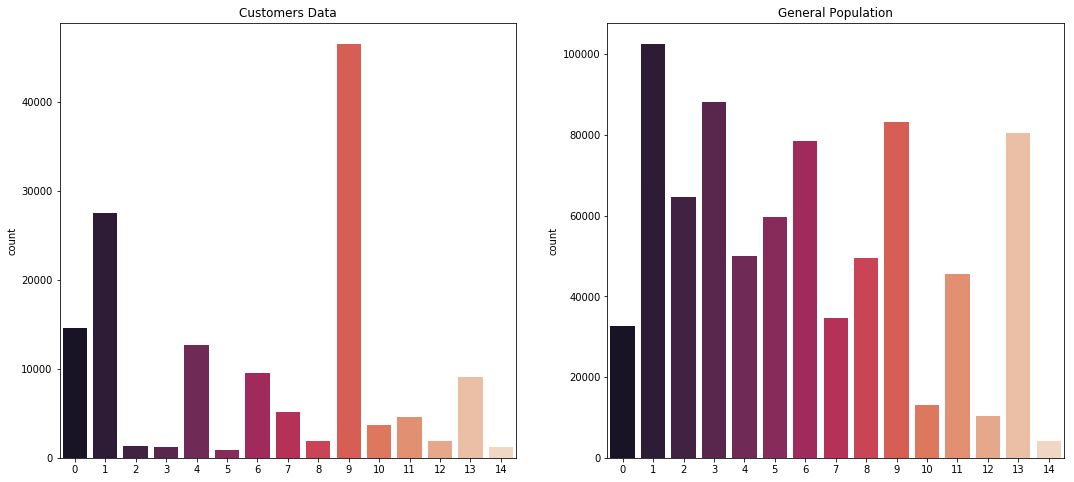

In [80]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig = plt.figure(figsize=(18, 8))    
ax1 = fig.add_subplot(121)
ax1.title.set_text("Customers Data")
sns.countplot(kmeans_customers,ax=ax1,palette="rocket")
    
ax2 = fig.add_subplot(122)
ax2.title.set_text("General Population")
sns.countplot(general_prediction, ax=ax2,palette="rocket")

In [81]:
general_population = pd.Series(general_prediction).value_counts().sort_index()
customer_population = pd.Series(kmeans_customers).value_counts().sort_index()

In [82]:
combined_df = pd.concat([general_population,customer_population],axis=1)
combined_df.columns = [ 'general_popu', 'customers_popu']

combined_df['general_prop'] = combined_df['general_popu'] / combined_df['general_popu'].sum()
combined_df['customers_prop'] = combined_df['customers_popu'] / combined_df['customers_popu'].sum()

combined_df

,general_popu,customers_popu,general_prop,customers_prop
0,32746,14616,0.041083,0.103228
1,102585,27483,0.128701,0.194103
2,64663,1350,0.081125,0.009535
3,88020,1242,0.110428,0.008772
4,50003,12613,0.062733,0.089081
5,59589,870,0.074759,0.006145
6,78541,9524,0.098536,0.067265
7,34577,5093,0.043380,0.035970
8,49522,1941,0.062130,0.013709
9,83288,46515,0.104492,0.328519


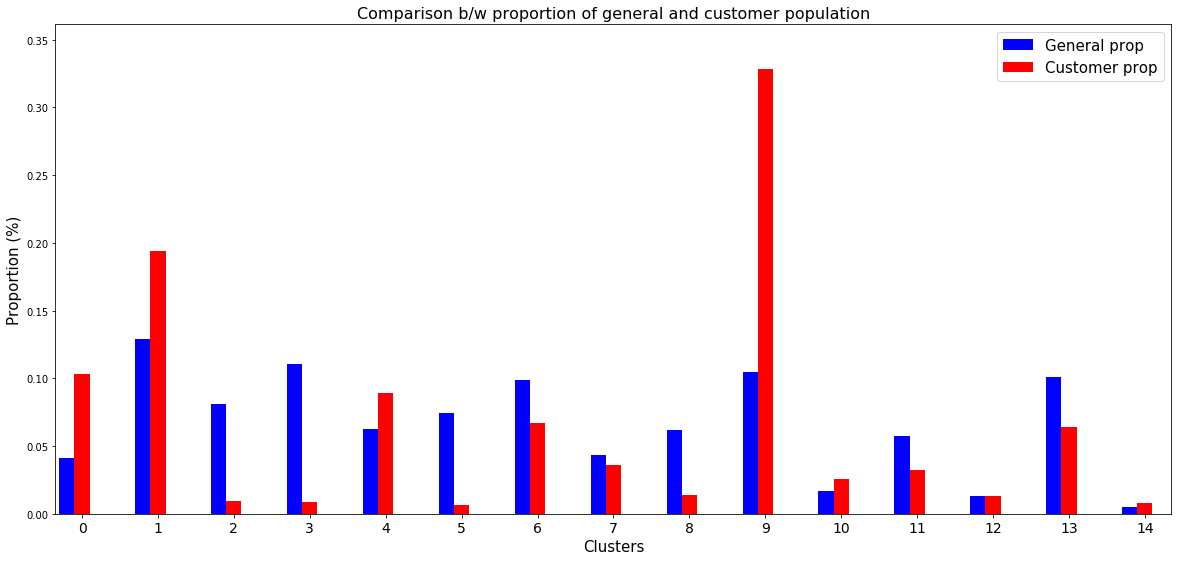

In [83]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1,1,1)

ax = combined_df['general_prop'].plot( kind='bar',color='b',width=-0.2, align='edge',position=0)
ax = combined_df['customers_prop'].plot(kind='bar',color='r',width = 0.2, align='edge',position=1)

ax.margins(x=0.5,y=0.1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Proportion (%)', fontsize=15)

ax.tick_params(axis = 'x', which = 'major', labelsize = 14)
plt.xticks(rotation=360,)

plt.legend(('General prop', 'Customer prop'),fontsize=15)
plt.title('Comparison b/w proportion of general and customer population',fontsize=16)

plt.subplots_adjust(bottom=0.2)
plt.show()

In [84]:
customer_proportions_diff = combined_df['customers_prop'] - combined_df['general_prop']
customer_proportions_diff.sort_values(ascending=False, inplace=True)
print('Over-represented')
print(customer_proportions_diff[:3])
print('\nUnder-represented')
print(customer_proportions_diff[-3:])

Over-represented
9    0.224027
1    0.065401
0    0.062145
dtype: float64

Under-represented
5   -0.068615
2   -0.071591
3   -0.101657
dtype: float64


In [132]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_cluster_9 = pd.Series(model.cluster_centers_[9]).sort_values(ascending=False)
centroid_cluster_9.head()




0     4.052606
2     2.781902
16    0.603879
26    0.380959
29    0.329375
dtype: float64

In [133]:
inverted_cluster_9 = scaler.inverse_transform(pca.inverse_transform(centroid_cluster_9))
inverted_cluster_9 = pd.Series(inverted_cluster_9).round()
inverted_cluster_9.index = cleaned_customer_copy.columns
inverted_cluster_9


ALTERSKATEGORIE_GROB              3.0
ANREDE_KZ                         2.0
FINANZ_MINIMALIST                 3.0
FINANZ_SPARER                     2.0
FINANZ_VORSORGER                  4.0
FINANZ_ANLEGER                    2.0
FINANZ_UNAUFFAELLIGER             2.0
FINANZ_HAUSBAUER                  4.0
GREEN_AVANTGARDE                 -0.0
HEALTH_TYP                        2.0
LP_LEBENSPHASE_FEIN               9.0
LP_LEBENSPHASE_GROB               3.0
RETOURTYP_BK_S                    3.0
SEMIO_SOZ                         4.0
SEMIO_FAM                         4.0
SEMIO_REL                         3.0
SEMIO_MAT                         3.0
SEMIO_VERT                        4.0
SEMIO_LUST                        5.0
SEMIO_ERL                         5.0
SEMIO_KULT                        4.0
SEMIO_RAT                         3.0
SEMIO_KRIT                        5.0
SEMIO_DOM                         4.0
SEMIO_KAEM                        5.0
SEMIO_PFLICHT                     3.0
SEMIO_TRADV 

In [134]:
weight_map(cleaned_customer_copy,pca,0)

                                       0
LP_STATUS_GROB_1.0              0.188860
CAMEO_INTL_2015_WEALTH          0.180016
HH_EINKOMMEN_SCORE              0.179941
PLZ8_ANTG3                      0.179789
PLZ8_ANTG4                      0.174548
PLZ8_BAUMAX                     0.170392
ORTSGR_KLS9                     0.153803
EWDICHTE                        0.152187
FINANZ_HAUSBAUER                0.146951
LP_STATUS_FEIN_1.0              0.127139
KBA05_ANTG4                     0.124475
PLZ8_ANTG2                      0.123178
ANZ_HAUSHALTE_AKTIV             0.113142
ARBEIT                          0.111902
KBA05_ANTG3                     0.111244
CAMEO_DEUG_2015_9               0.110254
LP_STATUS_FEIN_2.0              0.106127
RELAT_AB                        0.105677
FINANZTYP_1                     0.101854
FINANZ_SPARER                   0.099610
LP_FAMILIE_GROB_1.0             0.098761
LP_FAMILIE_FEIN_1.0             0.098761
CAMEO_DEUG_2015_8               0.090529
PRAEGENDE_JUGEND

In [135]:
weight_map(cleaned_customer_copy,pca,2)

                                       2
SEMIO_VERT                      0.316960
SEMIO_FAM                       0.257876
SEMIO_SOZ                       0.255267
SEMIO_KULT                      0.249147
FINANZTYP_5                     0.135816
FINANZ_MINIMALIST               0.132067
SHOPPER_TYP_0.0                 0.121901
ZABEOTYP_1                      0.121320
SEMIO_REL                       0.112588
SEMIO_MAT                       0.087840
GREEN_AVANTGARDE                0.084041
RETOURTYP_BK_S                  0.073788
ORTSGR_KLS9                     0.068735
EWDICHTE                        0.068223
LP_STATUS_GROB_5.0              0.061260
LP_STATUS_FEIN_10.0             0.061260
W_KEIT_KIND_HH                  0.057298
PLZ8_BAUMAX                     0.053260
SHOPPER_TYP_1.0                 0.052601
PLZ8_ANTG4                      0.051066
PLZ8_ANTG3                      0.050372
ZABEOTYP_6                      0.046506
FINANZ_VORSORGER                0.046208
LP_STATUS_FEIN_3

In [136]:
weight_map(cleaned_customer_copy,pca,16)

                             16
CAMEO_DEUG_2015_5      0.204181
LP_STATUS_FEIN_2.0     0.198435
SHOPPER_TYP_3.0        0.171512
LP_FAMILIE_GROB_3.0    0.168732
FINANZTYP_1            0.155426
FINANZ_UNAUFFAELLIGER  0.148175
CAMEO_DEUG_2015_7      0.145937
NATIONALITAET_KZ_1.0   0.116184
LP_FAMILIE_FEIN_4.0    0.110166
CAMEO_DEU_2015_5C      0.098500
FINANZTYP_2            0.096998
SEMIO_LUST             0.096649
SHOPPER_TYP_0.0        0.096125
CAMEO_DEU_2015_5B      0.094797
LP_FAMILIE_FEIN_3.0    0.090881
CAMEO_DEU_2015_5A      0.090686
LP_FAMILIE_FEIN_5.0    0.090448
LP_STATUS_GROB_1.0     0.090008
CAMEO_DEU_2015_5D      0.085983
CAMEO_DEU_2015_7A      0.084974
CAMEO_DEUG_2015_6      0.083504
ALTERSKATEGORIE_GROB   0.082083
CAMEO_DEU_2015_7B      0.081665
ZABEOTYP_4             0.073573
LP_STATUS_GROB_4.0     0.073320
FINANZTYP_3            0.071878
ONLINE_AFFINITAET      0.070592
FINANZ_SPARER          0.069071
MIN_GEBAEUDEJAHR       0.067682
CAMEO_DEU_2015_6B      0.064241
...     

In [137]:
weight_map(cleaned_customer_copy,pca,26)

                                 26
NATIONALITAET_KZ_2.0       0.379008
SHOPPER_TYP_1.0            0.206043
NATIONALITAET_KZ_3.0       0.203360
LP_STATUS_FEIN_8.0         0.174014
ZABEOTYP_4                 0.138459
GFK_URLAUBERTYP_12.0       0.132784
CAMEO_INTL_2015_LIFESTAGE  0.126689
ZABEOTYP_3                 0.090438
ALTERSKATEGORIE_GROB       0.086823
FINANZTYP_4                0.084681
CAMEO_DEU_2015_8C          0.077676
ARBEIT                     0.076419
CJT_GESAMTTYP_5.0          0.075775
VERS_TYP                   0.074187
CAMEO_DEU_2015_2D          0.072316
SEMIO_ERL                  0.069081
LP_FAMILIE_FEIN_6.0        0.067728
CAMEO_DEU_2015_4C          0.063436
CAMEO_DEUG_2015_2          0.060267
SEMIO_KRIT                 0.058011
LP_STATUS_FEIN_6.0         0.057590
GEBAEUDETYP_8.0            0.057334
CAMEO_DEU_2015_9A          0.057177
SEMIO_LUST                 0.054179
KBA05_ANTG2                0.053666
MIN_GEBAEUDEJAHR           0.052031
SEMIO_SOZ                  0

In [138]:
weight_map(cleaned_customer_copy,pca,29)

                                    29
SHOPPER_TYP_1.0               0.229294
WOHNDAUER_2008                0.226170
CJT_GESAMTTYP_3.0             0.190646
LP_STATUS_FEIN_5.0            0.180001
LP_FAMILIE_FEIN_5.0           0.167112
FINANZTYP_4                   0.149941
LP_FAMILIE_FEIN_8.0           0.147888
ZABEOTYP_5                    0.145201
LP_STATUS_FEIN_1.0            0.137189
SEMIO_LUST                    0.127295
NATIONALITAET_KZ_2.0          0.126645
PLZ8_BAUMAX                   0.101990
LP_FAMILIE_GROB_3.0           0.101706
ZABEOTYP_1                    0.100140
CAMEO_DEU_2015_7B             0.100083
LP_STATUS_FEIN_7.0            0.086494
ANZ_TITEL                     0.084350
GFK_URLAUBERTYP_1.0           0.081698
PLZ8_ANTG3                    0.079929
PLZ8_ANTG4                    0.078670
FINANZTYP_6                   0.077264
WOHNLAGE                      0.073895
LP_STATUS_FEIN_9.0            0.072848
PRAEGENDE_JUGENDJAHRE_DECADE  0.068898
FINANZ_SPARER            

In [139]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_cluster_5 = pd.Series(model.cluster_centers_[5]).sort_values(ascending=False)
centroid_cluster_5.head()


5     1.813808
20    1.142491
37    1.100046
29    1.015981
31    0.905238
dtype: float64

In [140]:
inverted_cluster_5 = scaler.inverse_transform(pca.inverse_transform(centroid_cluster_5))
inverted_cluster_5 = pd.Series(inverted_cluster_5).round()
inverted_cluster_5.index = cleaned_customer_copy.columns
inverted_cluster_5


ALTERSKATEGORIE_GROB               3.0
ANREDE_KZ                          1.0
FINANZ_MINIMALIST                  3.0
FINANZ_SPARER                      2.0
FINANZ_VORSORGER                   4.0
FINANZ_ANLEGER                     2.0
FINANZ_UNAUFFAELLIGER              2.0
FINANZ_HAUSBAUER                   4.0
GREEN_AVANTGARDE                  -0.0
HEALTH_TYP                         2.0
LP_LEBENSPHASE_FEIN               17.0
LP_LEBENSPHASE_GROB                5.0
RETOURTYP_BK_S                     3.0
SEMIO_SOZ                          4.0
SEMIO_FAM                          4.0
SEMIO_REL                          4.0
SEMIO_MAT                          4.0
SEMIO_VERT                         5.0
SEMIO_LUST                         4.0
SEMIO_ERL                          4.0
SEMIO_KULT                         4.0
SEMIO_RAT                          3.0
SEMIO_KRIT                         4.0
SEMIO_DOM                          4.0
SEMIO_KAEM                         4.0
SEMIO_PFLICHT            

In [141]:
weight_map(cleaned_customer_copy,pca,5)


                             5
LP_STATUS_GROB_2.0    0.335454
LP_STATUS_FEIN_4.0    0.249985
FINANZ_HAUSBAUER      0.215617
LP_STATUS_FEIN_3.0    0.166703
LP_FAMILIE_GROB_5.0   0.161498
LP_STATUS_GROB_3.0    0.149385
GEBAEUDETYP_3.0       0.135914
LP_FAMILIE_FEIN_10.0  0.132287
LP_STATUS_FEIN_6.0    0.127034
KBA13_ANZAHL_PKW      0.124138
PLZ8_GBZ              0.107961
CAMEO_DEUG_2015_6     0.101480
FINANZTYP_1           0.100910
LP_STATUS_FEIN_5.0    0.099413
INNENSTADT            0.091011
ANZ_PERSONEN          0.089709
KBA05_ANTG2           0.087126
PLZ8_HHZ              0.080745
CAMEO_DEU_2015_6B     0.076373
HH_EINKOMMEN_SCORE    0.076202
LP_STATUS_FEIN_7.0    0.076055
WOHNLAGE              0.074718
LP_LEBENSPHASE_GROB   0.069700
SEMIO_LUST            0.068969
CAMEO_DEU_2015_5D     0.066965
LP_FAMILIE_FEIN_11.0  0.065901
BALLRAUM              0.064605
CAMEO_DEUG_2015_5     0.062707
SHOPPER_TYP_0.0       0.062378
WOHNDAUER_2008        0.062378
...                        ...
LP_FAMIL

In [142]:
weight_map(cleaned_customer_copy,pca,20)


                                      20
CAMEO_DEUG_2015_1               0.258676
LP_FAMILIE_GROB_4.0             0.211538
CAMEO_DEUG_2015_2               0.210207
LP_STATUS_FEIN_7.0              0.169559
LP_FAMILIE_FEIN_8.0             0.160217
CAMEO_DEU_2015_1A               0.159488
ANZ_TITEL                       0.134458
CAMEO_DEU_2015_2D               0.133740
LP_STATUS_FEIN_5.0              0.131462
REGIOTYP                        0.127040
VERS_TYP                        0.126298
LP_FAMILIE_FEIN_7.0             0.121272
KKK                             0.109936
CAMEO_DEU_2015_1E               0.108896
CAMEO_DEU_2015_2B               0.104986
SHOPPER_TYP_0.0                 0.103671
ZABEOTYP_4                      0.102401
CAMEO_DEU_2015_1B               0.101446
CAMEO_DEU_2015_1C               0.100485
CAMEO_DEU_2015_1D               0.100011
LP_STATUS_GROB_3.0              0.099471
GEBAEUDETYP_RASTER              0.091369
FINANZ_VORSORGER                0.091343
CAMEO_DEU_2015_2

In [143]:
weight_map(cleaned_customer_copy,pca,37)


                                      37
LP_STATUS_FEIN_8.0              0.332622
CJT_GESAMTTYP_6.0               0.260082
LP_STATUS_FEIN_5.0              0.197157
SHOPPER_TYP_0.0                 0.183030
LP_STATUS_FEIN_1.0              0.177482
VERS_TYP                        0.175823
FINANZTYP_4                     0.171330
GFK_URLAUBERTYP_9.0             0.140698
NATIONALITAET_KZ_3.0            0.133396
GFK_URLAUBERTYP_4.0             0.116993
CJT_GESAMTTYP_2.0               0.109906
ZABEOTYP_1                      0.109807
LP_FAMILIE_FEIN_3.0             0.107590
LP_FAMILIE_FEIN_6.0             0.097336
ONLINE_AFFINITAET               0.083532
FINANZTYP_2                     0.078412
LP_FAMILIE_FEIN_8.0             0.077489
PRAEGENDE_JUGENDJAHRE_MOVEMENT  0.066197
CAMEO_DEU_2015_4A               0.064043
PLZ8_BAUMAX                     0.062221
LP_FAMILIE_FEIN_11.0            0.061387
FINANZ_VORSORGER                0.059821
PLZ8_ANTG3                      0.057458
GFK_URLAUBERTYP_

In [144]:
weight_map(cleaned_customer_copy,pca,29)


                                    29
SHOPPER_TYP_1.0               0.229294
WOHNDAUER_2008                0.226170
CJT_GESAMTTYP_3.0             0.190646
LP_STATUS_FEIN_5.0            0.180001
LP_FAMILIE_FEIN_5.0           0.167112
FINANZTYP_4                   0.149941
LP_FAMILIE_FEIN_8.0           0.147888
ZABEOTYP_5                    0.145201
LP_STATUS_FEIN_1.0            0.137189
SEMIO_LUST                    0.127295
NATIONALITAET_KZ_2.0          0.126645
PLZ8_BAUMAX                   0.101990
LP_FAMILIE_GROB_3.0           0.101706
ZABEOTYP_1                    0.100140
CAMEO_DEU_2015_7B             0.100083
LP_STATUS_FEIN_7.0            0.086494
ANZ_TITEL                     0.084350
GFK_URLAUBERTYP_1.0           0.081698
PLZ8_ANTG3                    0.079929
PLZ8_ANTG4                    0.078670
FINANZTYP_6                   0.077264
WOHNLAGE                      0.073895
LP_STATUS_FEIN_9.0            0.072848
PRAEGENDE_JUGENDJAHRE_DECADE  0.068898
FINANZ_SPARER            

In [145]:
weight_map(cleaned_customer_copy,pca,31)

                                 31
SHOPPER_TYP_3.0            0.286284
FINANZTYP_4                0.263914
GEBAEUDETYP_8.0            0.212898
LP_STATUS_FEIN_1.0         0.176027
ARBEIT                     0.175828
RELAT_AB                   0.169411
LP_STATUS_FEIN_5.0         0.163009
CAMEO_DEU_2015_7A          0.136539
LP_FAMILIE_FEIN_11.0       0.115105
PLZ8_GBZ                   0.112561
CAMEO_INTL_2015_WEALTH     0.107591
PLZ8_ANTG1                 0.096530
GEBAEUDETYP_RASTER         0.096190
GFK_URLAUBERTYP_11.0       0.095098
CJT_GESAMTTYP_1.0          0.087563
ZABEOTYP_5                 0.081376
CAMEO_DEUG_2015_9          0.079218
CAMEO_DEU_2015_9A          0.077726
KONSUMNAEHE                0.075979
CJT_GESAMTTYP_3.0          0.075450
NATIONALITAET_KZ_2.0       0.074797
CAMEO_DEU_2015_8A          0.072645
KBA05_ANTG1                0.072447
FINANZTYP_5                0.071586
CJT_GESAMTTYP_5.0          0.071484
KBA05_GBZ                  0.066649
MOBI_REGIO                 0

In [155]:
print(inverted_cluster_9['CAMEO_INTL_2015_WEALTH'])
print(inverted_cluster_9['HH_EINKOMMEN_SCORE'])
print(inverted_cluster_9['ALTERSKATEGORIE_GROB'])
print(inverted_cluster_9['ANREDE_KZ'])
print("------------")
print(inverted_cluster_5['FINANZ_HAUSBAUER'])
print(inverted_cluster_5['ALTERSKATEGORIE_GROB'])
print(inverted_cluster_5['ANREDE_KZ'])


4.0
5.0
3.0
2.0
------------
4.0
3.0
1.0


### Conclusion

##### Over-Represented: 

The most over-represented cluster in customer data is Cluster 9. This cluster represents female population who are low income earners, less affluent household, dreamful, family minded, active middle class,orientation-seeking low-income earners and family shoppers who are foreigners.

##### Under-Represented

The most under-represented cluster in customer data is Cluster 5. This cluster represents male population who are average earners,villagers having low home ownership. This also includes upper class German CAMEO families in the age group 46 - 60 years old.

### Discussion 3.3: Compare Customer Data to Demographics Data

According to the cluster analysis, the segments of the population that are relatively popular with the mail-order company are the females who are low income earners, less affluent household, dreamful, family minded, active middle class,orientation-seeking low-income earners and family shoppers who are foreigners.

According to the cluster analysis, the segments of the population that are relatively unpopular with the mail-order company are the males who are average earners,villagers having low home ownership. This also includes upper class German CAMEO families in the age group 46 - 60 years old.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.